In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import logging

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torchvision.models as models
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader, Subset

In [3]:
# logging.basicConfig(format='%(asctime)s - %(name)s - %(levelname)s - %(message)s',
#                     datefmt='%d/%m/%Y %H:%M:%S',
#                     level=logging.INFO)

import datetime
from pathlib import Path

checkpoint_path = Path("checkpoints")
checkpoint_path.mkdir(exist_ok=True, parents=True)


TIMESTAMP = datetime.datetime.today().strftime("%y%m%d_%H:%M")
log_file = checkpoint_path/f"train_{TIMESTAMP}.log"
logging.basicConfig(
    format="%(asctime)s - %(name)s - %(levelname)s - %(message)s",
    datefmt="%d/%m/%Y %H:%M:%S",
    level=logging.INFO,
    handlers=[logging.FileHandler(log_file), logging.StreamHandler()],
)
logger = logging.getLogger(__name__)

In [4]:
device = "cuda:0" if torch.cuda.is_available() else "cpu"

In [5]:
trnsf = {
    'train': transforms.Compose([
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.ToTensor(),
        transforms.Normalize(0.5, 0.5),
    ]),
    'test': transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(0.5, 0.5),
    ])
}

In [29]:
ds_train = datasets.MNIST(root='.', train=True, transform=trnsf['train'], download=True)
ds_train = Subset(ds_train, list(range(80)))

ds_eval = datasets.MNIST(root='.', train=False, transform=trnsf['test'], download=True)
ds_eval = Subset(ds_eval, list(range(20)))

In [30]:
def imshow(im: torch.Tensor):
    im = im * 0.5 + 0.5
    im_np = im.numpy()
    im_np = im_np.transpose([1, 2, 0])
    plt.axis('off')
    plt.imshow(im_np, cmap='gray')

target: 4


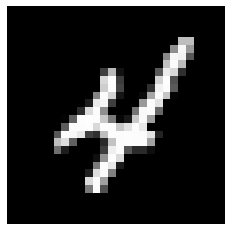

In [31]:
import random

# show a random image
idx = random.randint(0, len(ds_train))
x = ds_train[idx]

imshow(x[0])
print(f"target: {x[1]}")

In [32]:
n_classes = len(torch.unique(ds_train.dataset.targets).tolist())

In [33]:
model = models.resnet18()
model.conv1 = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
model.fc = nn.Linear(512, n_classes)
model.to(device);

In [34]:
from lib.data import LabelSmoothingLoss

optimizer = optim.Adam(model.parameters(), lr=3e-4)

# For the default scheduler, use a cooldown of 1000 epochs to ensure that the
# learning rate is only decayed once. Reducing the LR only once prevents problems
# with decaying too much/fast, as proposed by Andrej Karpathy in a 27-08-21 tweet.
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode="min", factor=0.1,
    patience=10, cooldown=1000, verbose=True
)  

criterion = LabelSmoothingLoss(n_classes, confidence=0.9)

In [37]:
from lib.trainer import TrainerConfig, Trainer
from lib.metrics import AccuracyCallback
from lib.callbacks import EarlyStoppingCallback, MLFlowCallback, CheckpointCallback
from lib.torch_utils import set_seed

set_seed(1337)

config = TrainerConfig(
    batch_size=32, 
    max_epochs=30,
#     use_swa=True,
)
trainer = Trainer(
    config=config, 
    model=model, 
    optimizer=optimizer, 
    scheduler=scheduler,
    train_ds=ds_train, 
    eval_ds=ds_eval,
    loss_fn=criterion,
    callbacks=[
        AccuracyCallback(monitor=True), 
        CheckpointCallback(checkpoint_path, monitor="accuracy"),
#         EarlyStoppingCallback(max_epochs_no_change=5)
        MLFlowCallback(experiment_name="default", artifacts_to_log=[log_file])
    ]
)

05/09/2021 12:10:12 - lib.trainer - INFO - Using mixed precision training.


In [38]:
trainer.train()

100%|██████████| 1/1 [00:00<00:00,  3.04it/s]
05/09/2021 12:10:13 - lib.trainer - INFO - epoch 0 - train_loss: 0.5551. 
05/09/2021 12:10:13 - lib.callbacks - INFO - New best score - accuracy: 0.6500
05/09/2021 12:10:13 - lib.trainer - INFO - epoch 0 - eval_loss: 1.6292. accuracy: 0.6500. 
  0%|          | 0/1 [00:00<?, ?it/s]

0.0003


100%|██████████| 1/1 [00:00<00:00,  2.90it/s]
05/09/2021 12:10:14 - lib.trainer - INFO - epoch 1 - train_loss: 0.5654. 
05/09/2021 12:10:14 - lib.trainer - INFO - epoch 1 - eval_loss: 1.6300. accuracy: 0.6500. 
  0%|          | 0/1 [00:00<?, ?it/s]

0.0003


100%|██████████| 1/1 [00:00<00:00,  3.05it/s]
05/09/2021 12:10:14 - lib.trainer - INFO - epoch 2 - train_loss: 0.6034. 
05/09/2021 12:10:14 - lib.trainer - INFO - epoch 2 - eval_loss: 1.6264. accuracy: 0.6500. 
  0%|          | 0/1 [00:00<?, ?it/s]

0.0003


100%|██████████| 1/1 [00:00<00:00,  2.77it/s]
05/09/2021 12:10:15 - lib.trainer - INFO - epoch 3 - train_loss: 0.5598. 
05/09/2021 12:10:15 - lib.trainer - INFO - epoch 3 - eval_loss: 1.6204. accuracy: 0.6000. 
  0%|          | 0/1 [00:00<?, ?it/s]

0.0003


100%|██████████| 1/1 [00:00<00:00,  2.85it/s]
05/09/2021 12:10:15 - lib.trainer - INFO - epoch 4 - train_loss: 0.5757. 
05/09/2021 12:10:15 - lib.trainer - INFO - epoch 4 - eval_loss: 1.5896. accuracy: 0.6000. 
  0%|          | 0/1 [00:00<?, ?it/s]

0.0003


100%|██████████| 1/1 [00:00<00:00,  2.71it/s]
05/09/2021 12:10:16 - lib.trainer - INFO - epoch 5 - train_loss: 0.6170. 
05/09/2021 12:10:16 - lib.trainer - INFO - epoch 5 - eval_loss: 1.5586. accuracy: 0.6000. 
  0%|          | 0/1 [00:00<?, ?it/s]

0.0003


100%|██████████| 1/1 [00:00<00:00,  2.95it/s]
05/09/2021 12:10:16 - lib.trainer - INFO - epoch 6 - train_loss: 0.5630. 
05/09/2021 12:10:16 - lib.trainer - INFO - epoch 6 - eval_loss: 1.5386. accuracy: 0.6500. 
  0%|          | 0/1 [00:00<?, ?it/s]

0.0003


100%|██████████| 1/1 [00:00<00:00,  3.01it/s]
05/09/2021 12:10:16 - lib.trainer - INFO - epoch 7 - train_loss: 0.5546. 
05/09/2021 12:10:16 - lib.trainer - INFO - epoch 7 - eval_loss: 1.5272. accuracy: 0.6500. 
  0%|          | 0/1 [00:00<?, ?it/s]

0.0003


100%|██████████| 1/1 [00:00<00:00,  2.81it/s]
05/09/2021 12:10:17 - lib.trainer - INFO - epoch 8 - train_loss: 0.5679. 
05/09/2021 12:10:17 - lib.trainer - INFO - epoch 8 - eval_loss: 1.5150. accuracy: 0.6500. 
  0%|          | 0/1 [00:00<?, ?it/s]

0.0003


100%|██████████| 1/1 [00:00<00:00,  2.38it/s]
05/09/2021 12:10:17 - lib.trainer - INFO - epoch 9 - train_loss: 0.5576. 
05/09/2021 12:10:17 - lib.trainer - INFO - epoch 9 - eval_loss: 1.5151. accuracy: 0.6500. 
  0%|          | 0/1 [00:00<?, ?it/s]

0.0003


100%|██████████| 1/1 [00:00<00:00,  3.01it/s]
05/09/2021 12:10:18 - lib.trainer - INFO - epoch 10 - train_loss: 0.5549. 
05/09/2021 12:10:18 - lib.trainer - INFO - epoch 10 - eval_loss: 1.5055. accuracy: 0.6500. 
  0%|          | 0/1 [00:00<?, ?it/s]

0.0003


100%|██████████| 1/1 [00:00<00:00,  2.41it/s]
05/09/2021 12:10:18 - lib.trainer - INFO - epoch 11 - train_loss: 0.5668. 
05/09/2021 12:10:18 - lib.trainer - INFO - epoch 11 - eval_loss: 1.4915. accuracy: 0.6500. 
  0%|          | 0/1 [00:00<?, ?it/s]

0.0003


100%|██████████| 1/1 [00:00<00:00,  2.37it/s]
05/09/2021 12:10:19 - lib.trainer - INFO - epoch 12 - train_loss: 0.5541. 
05/09/2021 12:10:19 - lib.callbacks - INFO - New best score - accuracy: 0.7000
05/09/2021 12:10:19 - lib.trainer - INFO - epoch 12 - eval_loss: 1.4822. accuracy: 0.7000. 
  0%|          | 0/1 [00:00<?, ?it/s]

0.0003


100%|██████████| 1/1 [00:00<00:00,  2.69it/s]
05/09/2021 12:10:19 - lib.trainer - INFO - epoch 13 - train_loss: 0.5671. 
05/09/2021 12:10:19 - lib.trainer - INFO - epoch 13 - eval_loss: 1.4725. accuracy: 0.6500. 
  0%|          | 0/1 [00:00<?, ?it/s]

0.0003


100%|██████████| 1/1 [00:00<00:00,  2.43it/s]
05/09/2021 12:10:20 - lib.trainer - INFO - epoch 14 - train_loss: 0.5726. 
05/09/2021 12:10:20 - lib.trainer - INFO - epoch 14 - eval_loss: 1.4794. accuracy: 0.6500. 
  0%|          | 0/1 [00:00<?, ?it/s]

0.0003


100%|██████████| 1/1 [00:00<00:00,  2.65it/s]
05/09/2021 12:10:20 - lib.trainer - INFO - epoch 15 - train_loss: 0.5582. 
05/09/2021 12:10:20 - lib.trainer - INFO - epoch 15 - eval_loss: 1.4901. accuracy: 0.6500. 
  0%|          | 0/1 [00:00<?, ?it/s]

0.0003


100%|██████████| 1/1 [00:00<00:00,  2.30it/s]
05/09/2021 12:10:21 - lib.trainer - INFO - epoch 16 - train_loss: 0.5587. 
05/09/2021 12:10:21 - lib.trainer - INFO - epoch 16 - eval_loss: 1.4887. accuracy: 0.6500. 
  0%|          | 0/1 [00:00<?, ?it/s]

0.0003


100%|██████████| 1/1 [00:00<00:00,  2.25it/s]
05/09/2021 12:10:21 - lib.trainer - INFO - epoch 17 - train_loss: 0.5531. 
05/09/2021 12:10:21 - lib.trainer - INFO - epoch 17 - eval_loss: 1.4916. accuracy: 0.7000. 
  0%|          | 0/1 [00:00<?, ?it/s]

0.0003


100%|██████████| 1/1 [00:00<00:00,  2.14it/s]
05/09/2021 12:10:22 - lib.trainer - INFO - epoch 18 - train_loss: 0.5695. 
05/09/2021 12:10:22 - lib.trainer - INFO - epoch 18 - eval_loss: 1.4961. accuracy: 0.7000. 
  0%|          | 0/1 [00:00<?, ?it/s]

0.0003


100%|██████████| 1/1 [00:00<00:00,  3.03it/s]
05/09/2021 12:10:22 - lib.trainer - INFO - epoch 19 - train_loss: 0.5669. 
05/09/2021 12:10:22 - lib.trainer - INFO - epoch 19 - eval_loss: 1.4905. accuracy: 0.7000. 
  0%|          | 0/1 [00:00<?, ?it/s]

0.0003


100%|██████████| 1/1 [00:00<00:00,  3.02it/s]
05/09/2021 12:10:23 - lib.trainer - INFO - epoch 20 - train_loss: 0.5580. 
05/09/2021 12:10:23 - lib.trainer - INFO - epoch 20 - eval_loss: 1.4884. accuracy: 0.7000. 
  0%|          | 0/1 [00:00<?, ?it/s]

0.0003


100%|██████████| 1/1 [00:00<00:00,  2.23it/s]
05/09/2021 12:10:23 - lib.trainer - INFO - epoch 21 - train_loss: 0.5549. 
05/09/2021 12:10:23 - lib.trainer - INFO - epoch 21 - eval_loss: 1.4881. accuracy: 0.7000. 
  0%|          | 0/1 [00:00<?, ?it/s]

0.0003


100%|██████████| 1/1 [00:00<00:00,  2.74it/s]
05/09/2021 12:10:24 - lib.trainer - INFO - epoch 22 - train_loss: 0.5511. 
05/09/2021 12:10:24 - lib.callbacks - INFO - New best score - accuracy: 0.7500
05/09/2021 12:10:24 - lib.trainer - INFO - epoch 22 - eval_loss: 1.4843. accuracy: 0.7500. 
  0%|          | 0/1 [00:00<?, ?it/s]

0.0003


100%|██████████| 1/1 [00:00<00:00,  2.98it/s]
05/09/2021 12:10:24 - lib.trainer - INFO - epoch 23 - train_loss: 0.5565. 
05/09/2021 12:10:24 - lib.trainer - INFO - epoch 23 - eval_loss: 1.4803. accuracy: 0.7500. 
  0%|          | 0/1 [00:00<?, ?it/s]

0.0003


100%|██████████| 1/1 [00:00<00:00,  2.00it/s]
05/09/2021 12:10:25 - lib.trainer - INFO - epoch 24 - train_loss: 0.5540. 
05/09/2021 12:10:25 - lib.trainer - INFO - epoch 24 - eval_loss: 1.4790. accuracy: 0.7500. 
  0%|          | 0/1 [00:00<?, ?it/s]

0.0003
Epoch    65: reducing learning rate of group 0 to 3.0000e-05.


100%|██████████| 1/1 [00:00<00:00,  2.94it/s]
05/09/2021 12:10:25 - lib.trainer - INFO - epoch 25 - train_loss: 0.5548. 
05/09/2021 12:10:25 - lib.trainer - INFO - epoch 25 - eval_loss: 1.4777. accuracy: 0.7000. 
  0%|          | 0/1 [00:00<?, ?it/s]

2.9999999999999997e-05


100%|██████████| 1/1 [00:00<00:00,  2.26it/s]
05/09/2021 12:10:26 - lib.trainer - INFO - epoch 26 - train_loss: 0.5619. 
05/09/2021 12:10:26 - lib.trainer - INFO - epoch 26 - eval_loss: 1.4767. accuracy: 0.7000. 
  0%|          | 0/1 [00:00<?, ?it/s]

2.9999999999999997e-05


100%|██████████| 1/1 [00:00<00:00,  2.92it/s]
05/09/2021 12:10:26 - lib.trainer - INFO - epoch 27 - train_loss: 0.5554. 
05/09/2021 12:10:26 - lib.trainer - INFO - epoch 27 - eval_loss: 1.4750. accuracy: 0.7000. 
  0%|          | 0/1 [00:00<?, ?it/s]

2.9999999999999997e-05


100%|██████████| 1/1 [00:00<00:00,  1.99it/s]
05/09/2021 12:10:27 - lib.trainer - INFO - epoch 28 - train_loss: 0.5560. 
05/09/2021 12:10:27 - lib.trainer - INFO - epoch 28 - eval_loss: 1.4795. accuracy: 0.7000. 
  0%|          | 0/1 [00:00<?, ?it/s]

2.9999999999999997e-05


100%|██████████| 1/1 [00:00<00:00,  1.85it/s]
05/09/2021 12:10:27 - lib.trainer - INFO - epoch 29 - train_loss: 0.5599. 
05/09/2021 12:10:27 - lib.trainer - INFO - epoch 29 - eval_loss: 1.4827. accuracy: 0.7000. 
  0%|          | 0/1 [00:00<?, ?it/s]

2.9999999999999997e-05


100%|██████████| 1/1 [00:00<00:00,  2.21it/s]
05/09/2021 12:10:28 - lib.trainer - INFO - epoch 30 - train_loss: 0.5532. 
05/09/2021 12:10:28 - lib.trainer - INFO - epoch 30 - eval_loss: 1.4891. accuracy: 0.7000. 
  0%|          | 0/1 [00:00<?, ?it/s]

2.9999999999999997e-05


100%|██████████| 1/1 [00:00<00:00,  2.96it/s]
05/09/2021 12:10:28 - lib.trainer - INFO - epoch 31 - train_loss: 0.5518. 
05/09/2021 12:10:28 - lib.trainer - INFO - epoch 31 - eval_loss: 1.4879. accuracy: 0.7000. 
  0%|          | 0/1 [00:00<?, ?it/s]

2.9999999999999997e-05


100%|██████████| 1/1 [00:00<00:00,  2.41it/s]
05/09/2021 12:10:29 - lib.trainer - INFO - epoch 32 - train_loss: 0.5582. 
05/09/2021 12:10:29 - lib.trainer - INFO - epoch 32 - eval_loss: 1.4909. accuracy: 0.7000. 
  0%|          | 0/1 [00:00<?, ?it/s]

2.9999999999999997e-05


100%|██████████| 1/1 [00:00<00:00,  2.34it/s]
05/09/2021 12:10:29 - lib.trainer - INFO - epoch 33 - train_loss: 0.5504. 
05/09/2021 12:10:29 - lib.trainer - INFO - epoch 33 - eval_loss: 1.4899. accuracy: 0.7000. 
  0%|          | 0/1 [00:00<?, ?it/s]

2.9999999999999997e-05


100%|██████████| 1/1 [00:00<00:00,  2.84it/s]
05/09/2021 12:10:30 - lib.trainer - INFO - epoch 34 - train_loss: 0.5506. 
05/09/2021 12:10:30 - lib.trainer - INFO - epoch 34 - eval_loss: 1.4968. accuracy: 0.6500. 
  0%|          | 0/1 [00:00<?, ?it/s]

2.9999999999999997e-05


100%|██████████| 1/1 [00:00<00:00,  2.27it/s]
05/09/2021 12:10:30 - lib.trainer - INFO - epoch 35 - train_loss: 0.5473. 
05/09/2021 12:10:30 - lib.trainer - INFO - epoch 35 - eval_loss: 1.4951. accuracy: 0.7000. 
  0%|          | 0/1 [00:00<?, ?it/s]

2.9999999999999997e-05


100%|██████████| 1/1 [00:00<00:00,  2.10it/s]
05/09/2021 12:10:31 - lib.trainer - INFO - epoch 36 - train_loss: 0.5510. 
05/09/2021 12:10:31 - lib.trainer - INFO - epoch 36 - eval_loss: 1.4930. accuracy: 0.7000. 
  0%|          | 0/1 [00:00<?, ?it/s]

2.9999999999999997e-05


100%|██████████| 1/1 [00:00<00:00,  2.22it/s]
05/09/2021 12:10:31 - lib.trainer - INFO - epoch 37 - train_loss: 0.5482. 
05/09/2021 12:10:31 - lib.trainer - INFO - epoch 37 - eval_loss: 1.4978. accuracy: 0.7000. 
  0%|          | 0/1 [00:00<?, ?it/s]

2.9999999999999997e-05


100%|██████████| 1/1 [00:00<00:00,  1.90it/s]
05/09/2021 12:10:32 - lib.trainer - INFO - epoch 38 - train_loss: 0.5494. 
05/09/2021 12:10:32 - lib.trainer - INFO - epoch 38 - eval_loss: 1.5000. accuracy: 0.6500. 
  0%|          | 0/1 [00:00<?, ?it/s]

2.9999999999999997e-05


100%|██████████| 1/1 [00:00<00:00,  2.94it/s]
05/09/2021 12:10:32 - lib.trainer - INFO - epoch 39 - train_loss: 0.5472. 
05/09/2021 12:10:32 - lib.trainer - INFO - epoch 39 - eval_loss: 1.5010. accuracy: 0.6500. 
  0%|          | 0/1 [00:00<?, ?it/s]

2.9999999999999997e-05


100%|██████████| 1/1 [00:00<00:00,  2.91it/s]
05/09/2021 12:10:33 - lib.trainer - INFO - epoch 40 - train_loss: 0.5494. 
05/09/2021 12:10:33 - lib.trainer - INFO - epoch 40 - eval_loss: 1.5024. accuracy: 0.6500. 
  0%|          | 0/1 [00:00<?, ?it/s]

2.9999999999999997e-05


100%|██████████| 1/1 [00:00<00:00,  2.33it/s]
05/09/2021 12:10:33 - lib.trainer - INFO - epoch 41 - train_loss: 0.5486. 
05/09/2021 12:10:33 - lib.trainer - INFO - epoch 41 - eval_loss: 1.5031. accuracy: 0.6500. 
  0%|          | 0/1 [00:00<?, ?it/s]

2.9999999999999997e-05


100%|██████████| 1/1 [00:00<00:00,  1.90it/s]
05/09/2021 12:10:34 - lib.trainer - INFO - epoch 42 - train_loss: 0.5489. 
05/09/2021 12:10:34 - lib.trainer - INFO - epoch 42 - eval_loss: 1.5018. accuracy: 0.6500. 
  0%|          | 0/1 [00:00<?, ?it/s]

2.9999999999999997e-05


100%|██████████| 1/1 [00:00<00:00,  1.81it/s]
05/09/2021 12:10:34 - lib.trainer - INFO - epoch 43 - train_loss: 0.5472. 
05/09/2021 12:10:34 - lib.trainer - INFO - epoch 43 - eval_loss: 1.5038. accuracy: 0.6500. 
  0%|          | 0/1 [00:00<?, ?it/s]

2.9999999999999997e-05


100%|██████████| 1/1 [00:00<00:00,  2.27it/s]
05/09/2021 12:10:35 - lib.trainer - INFO - epoch 44 - train_loss: 0.5510. 
05/09/2021 12:10:35 - lib.trainer - INFO - epoch 44 - eval_loss: 1.5089. accuracy: 0.6500. 
  0%|          | 0/1 [00:00<?, ?it/s]

2.9999999999999997e-05


100%|██████████| 1/1 [00:00<00:00,  2.47it/s]
05/09/2021 12:10:35 - lib.trainer - INFO - epoch 45 - train_loss: 0.5490. 
05/09/2021 12:10:35 - lib.trainer - INFO - epoch 45 - eval_loss: 1.5106. accuracy: 0.6500. 
  0%|          | 0/1 [00:00<?, ?it/s]

2.9999999999999997e-05


100%|██████████| 1/1 [00:00<00:00,  2.95it/s]
05/09/2021 12:10:36 - lib.trainer - INFO - epoch 46 - train_loss: 0.5520. 
05/09/2021 12:10:36 - lib.trainer - INFO - epoch 46 - eval_loss: 1.5125. accuracy: 0.6500. 
  0%|          | 0/1 [00:00<?, ?it/s]

2.9999999999999997e-05


100%|██████████| 1/1 [00:00<00:00,  2.07it/s]
05/09/2021 12:10:36 - lib.trainer - INFO - epoch 47 - train_loss: 0.5523. 
05/09/2021 12:10:36 - lib.trainer - INFO - epoch 47 - eval_loss: 1.5152. accuracy: 0.6500. 
  0%|          | 0/1 [00:00<?, ?it/s]

2.9999999999999997e-05


100%|██████████| 1/1 [00:00<00:00,  1.55it/s]
05/09/2021 12:10:37 - lib.trainer - INFO - epoch 48 - train_loss: 0.5471. 
05/09/2021 12:10:37 - lib.trainer - INFO - epoch 48 - eval_loss: 1.5168. accuracy: 0.6500. 
  0%|          | 0/1 [00:00<?, ?it/s]

2.9999999999999997e-05


100%|██████████| 1/1 [00:00<00:00,  3.03it/s]
05/09/2021 12:10:38 - lib.trainer - INFO - epoch 49 - train_loss: 0.5496. 
05/09/2021 12:10:38 - lib.trainer - INFO - epoch 49 - eval_loss: 1.5165. accuracy: 0.6500. 
  0%|          | 0/1 [00:00<?, ?it/s]

2.9999999999999997e-05


100%|██████████| 1/1 [00:00<00:00,  1.97it/s]
05/09/2021 12:10:38 - lib.trainer - INFO - epoch 50 - train_loss: 0.5487. 
05/09/2021 12:10:38 - lib.trainer - INFO - epoch 50 - eval_loss: 1.5159. accuracy: 0.6500. 
  0%|          | 0/1 [00:00<?, ?it/s]

2.9999999999999997e-05


100%|██████████| 1/1 [00:00<00:00,  2.43it/s]
05/09/2021 12:10:39 - lib.trainer - INFO - epoch 51 - train_loss: 0.5473. 
05/09/2021 12:10:39 - lib.trainer - INFO - epoch 51 - eval_loss: 1.5161. accuracy: 0.6500. 
  0%|          | 0/1 [00:00<?, ?it/s]

2.9999999999999997e-05


100%|██████████| 1/1 [00:00<00:00,  2.04it/s]
05/09/2021 12:10:39 - lib.trainer - INFO - epoch 52 - train_loss: 0.5480. 
05/09/2021 12:10:39 - lib.trainer - INFO - epoch 52 - eval_loss: 1.5171. accuracy: 0.6500. 
  0%|          | 0/1 [00:00<?, ?it/s]

2.9999999999999997e-05


100%|██████████| 1/1 [00:00<00:00,  3.00it/s]
05/09/2021 12:10:40 - lib.trainer - INFO - epoch 53 - train_loss: 0.5476. 
05/09/2021 12:10:40 - lib.trainer - INFO - epoch 53 - eval_loss: 1.5223. accuracy: 0.6500. 
  0%|          | 0/1 [00:00<?, ?it/s]

2.9999999999999997e-05


100%|██████████| 1/1 [00:00<00:00,  1.84it/s]
05/09/2021 12:10:40 - lib.trainer - INFO - epoch 54 - train_loss: 0.5488. 
05/09/2021 12:10:40 - lib.trainer - INFO - epoch 54 - eval_loss: 1.5215. accuracy: 0.6500. 
  0%|          | 0/1 [00:00<?, ?it/s]

2.9999999999999997e-05


100%|██████████| 1/1 [00:00<00:00,  2.25it/s]
05/09/2021 12:10:41 - lib.trainer - INFO - epoch 55 - train_loss: 0.5487. 
05/09/2021 12:10:41 - lib.trainer - INFO - epoch 55 - eval_loss: 1.5236. accuracy: 0.6500. 
  0%|          | 0/1 [00:00<?, ?it/s]

2.9999999999999997e-05


100%|██████████| 1/1 [00:00<00:00,  2.01it/s]
05/09/2021 12:10:41 - lib.trainer - INFO - epoch 56 - train_loss: 0.5477. 
05/09/2021 12:10:41 - lib.trainer - INFO - epoch 56 - eval_loss: 1.5222. accuracy: 0.6500. 
  0%|          | 0/1 [00:00<?, ?it/s]

2.9999999999999997e-05


100%|██████████| 1/1 [00:00<00:00,  2.93it/s]
05/09/2021 12:10:42 - lib.trainer - INFO - epoch 57 - train_loss: 0.5480. 
05/09/2021 12:10:42 - lib.trainer - INFO - epoch 57 - eval_loss: 1.5178. accuracy: 0.6500. 
  0%|          | 0/1 [00:00<?, ?it/s]

2.9999999999999997e-05


100%|██████████| 1/1 [00:00<00:00,  2.25it/s]
05/09/2021 12:10:42 - lib.trainer - INFO - epoch 58 - train_loss: 0.5474. 
05/09/2021 12:10:42 - lib.trainer - INFO - epoch 58 - eval_loss: 1.5213. accuracy: 0.6500. 
  0%|          | 0/1 [00:00<?, ?it/s]

2.9999999999999997e-05


100%|██████████| 1/1 [00:00<00:00,  2.99it/s]
05/09/2021 12:10:43 - lib.trainer - INFO - epoch 59 - train_loss: 0.5472. 
05/09/2021 12:10:43 - lib.trainer - INFO - epoch 59 - eval_loss: 1.5201. accuracy: 0.6500. 
  0%|          | 0/1 [00:00<?, ?it/s]

2.9999999999999997e-05


100%|██████████| 1/1 [00:00<00:00,  1.78it/s]
05/09/2021 12:10:43 - lib.trainer - INFO - epoch 60 - train_loss: 0.5468. 
05/09/2021 12:10:43 - lib.trainer - INFO - epoch 60 - eval_loss: 1.5199. accuracy: 0.6500. 
  0%|          | 0/1 [00:00<?, ?it/s]

2.9999999999999997e-05


100%|██████████| 1/1 [00:00<00:00,  1.80it/s]
05/09/2021 12:10:44 - lib.trainer - INFO - epoch 61 - train_loss: 0.5482. 
05/09/2021 12:10:44 - lib.trainer - INFO - epoch 61 - eval_loss: 1.5223. accuracy: 0.6500. 
  0%|          | 0/1 [00:00<?, ?it/s]

2.9999999999999997e-05


100%|██████████| 1/1 [00:00<00:00,  2.98it/s]
05/09/2021 12:10:44 - lib.trainer - INFO - epoch 62 - train_loss: 0.5496. 
05/09/2021 12:10:44 - lib.trainer - INFO - epoch 62 - eval_loss: 1.5231. accuracy: 0.6500. 
  0%|          | 0/1 [00:00<?, ?it/s]

2.9999999999999997e-05


100%|██████████| 1/1 [00:00<00:00,  2.94it/s]
05/09/2021 12:10:45 - lib.trainer - INFO - epoch 63 - train_loss: 0.5469. 
05/09/2021 12:10:45 - lib.trainer - INFO - epoch 63 - eval_loss: 1.5239. accuracy: 0.6500. 
  0%|          | 0/1 [00:00<?, ?it/s]

2.9999999999999997e-05


100%|██████████| 1/1 [00:00<00:00,  2.06it/s]
05/09/2021 12:10:45 - lib.trainer - INFO - epoch 64 - train_loss: 0.5481. 
05/09/2021 12:10:45 - lib.trainer - INFO - epoch 64 - eval_loss: 1.5228. accuracy: 0.6500. 
  0%|          | 0/1 [00:00<?, ?it/s]

2.9999999999999997e-05


100%|██████████| 1/1 [00:00<00:00,  2.71it/s]
05/09/2021 12:10:46 - lib.trainer - INFO - epoch 65 - train_loss: 0.5461. 
05/09/2021 12:10:46 - lib.trainer - INFO - epoch 65 - eval_loss: 1.5213. accuracy: 0.6500. 
  0%|          | 0/1 [00:00<?, ?it/s]

2.9999999999999997e-05


100%|██████████| 1/1 [00:00<00:00,  2.67it/s]
05/09/2021 12:10:46 - lib.trainer - INFO - epoch 66 - train_loss: 0.5477. 
05/09/2021 12:10:46 - lib.trainer - INFO - epoch 66 - eval_loss: 1.5178. accuracy: 0.6500. 
  0%|          | 0/1 [00:00<?, ?it/s]

2.9999999999999997e-05


100%|██████████| 1/1 [00:00<00:00,  2.49it/s]
05/09/2021 12:10:47 - lib.trainer - INFO - epoch 67 - train_loss: 0.5463. 
05/09/2021 12:10:47 - lib.trainer - INFO - epoch 67 - eval_loss: 1.5200. accuracy: 0.6500. 
  0%|          | 0/1 [00:00<?, ?it/s]

2.9999999999999997e-05


100%|██████████| 1/1 [00:00<00:00,  1.87it/s]
05/09/2021 12:10:47 - lib.trainer - INFO - epoch 68 - train_loss: 0.5462. 
05/09/2021 12:10:48 - lib.trainer - INFO - epoch 68 - eval_loss: 1.5219. accuracy: 0.6500. 
  0%|          | 0/1 [00:00<?, ?it/s]

2.9999999999999997e-05


100%|██████████| 1/1 [00:00<00:00,  1.82it/s]
05/09/2021 12:10:48 - lib.trainer - INFO - epoch 69 - train_loss: 0.5462. 
05/09/2021 12:10:48 - lib.trainer - INFO - epoch 69 - eval_loss: 1.5247. accuracy: 0.6500. 


2.9999999999999997e-05
